In [8]:
# Vérifiez la version de TensorFlow pour assurer la compatibilité
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

# Importations des librairies nécessaires
import os
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

TensorFlow version: 2.20.0


In [9]:
# Chemins des données (à ajuster si nécessaire)
TRAIN_DIR = os.path.join('./', 'train')
TEST_DIR = os.path.join('./', 'test')

# Paramètres du modèle et de l'entraînement
IMAGE_SIZE = (128, 128) # Taille cible des images
BATCH_SIZE = 32         # Nombre d'images traitées à la fois
EPOCHS = 20             # Nombre de passes complètes sur les données d'entraînement

In [10]:
# 3.1. Augmentation et Normalisation pour l'entraînement
train_datagen = ImageDataGenerator(
    rescale=1./255,                 # Normalisation des pixels (0 à 1)
    rotation_range=20,              # Rotation aléatoire
    width_shift_range=0.2,          # Décalage horizontal
    height_shift_range=0.2,         # Décalage vertical
    shear_range=0.2,                # Cisaillement
    zoom_range=0.2,                 # Zoom aléatoire
    horizontal_flip=True,           # Miroir horizontal
    fill_mode='nearest',            # Stratégie de remplissage
    validation_split=0.15           # Utilise 15% des données d'entraînement pour la validation
)

# 3.2. Normalisation SANS Augmentation pour le test et la validation
# Le jeu de validation est créé à partir de TRAIN_DIR en utilisant validation_split
test_val_datagen = ImageDataGenerator(rescale=1./255) 

# 3.3. Chargement des données d'entraînement
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',            # Classification binaire (0 ou 1)
    subset='training'
)

# 3.4. Chargement des données de validation
validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

# 3.5. Chargement des données de test (sans augmentation ni split)
test_generator = test_val_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=1,                   # Batch de 1 pour une évaluation précise
    class_mode='binary',
    shuffle=False                   # Important : garder l'ordre pour l'évaluation
)

# Afficher l'index des classes pour la vérification
print(f"Index des classes: {train_generator.class_indices}")
CLASS_NAMES = list(train_generator.class_indices.keys())

Found 25713 images belonging to 2 classes.
Found 4537 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.
Index des classes: {'nowildfire': 0, 'wildfire': 1}


In [11]:
# Création du modèle séquentiel
model = Sequential([
    # Couche 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    # Couche 2
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    # Couche 3
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    # Flatten pour passer aux couches denses
    Flatten(),
    
    # Couche dense (Fully Connected)
    Dense(512, activation='relu'),
    Dropout(0.5), # Ajout de Dropout pour éviter l'overfitting
    
    # Couche de sortie pour la classification binaire
    # 'sigmoid' est utilisé pour la classification binaire (probabilité entre 0 et 1)
    Dense(1, activation='sigmoid') 
])

# Compilation du modèle
model.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss='binary_crossentropy',       # Perte pour la classification binaire
    metrics=['accuracy']
)

# Afficher un résumé du modèle
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,940,225 (49.36 MB)

 Trainable params: 12,939,777 (49.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [12]:
# Entraînement
history = model.fit(
    train_generator;,
    steps_per_epoch=train_generator.samples // BATCH_SIZE, # Nombre de steps par epoch
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE # Steps de validation
)

Epoch 1/20
803/803 ━━━━━━━━━━━━━━━━━━━━ 856s 1s/step - accuracy: 0.8969 - loss: 0.7700 - val_accuracy: 0.9685 - val_loss: 0.0924
Epoch 2/20
  1/803 ━━━━━━━━━━━━━━━━━━━━ 5:45 431ms/step - accuracy: 1.0000 - loss: 0.0951

C:\Users\Shapl\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


803/803 ━━━━━━━━━━━━━━━━━━━━ 53s 65ms/step - accuracy: 1.0000 - loss: 0.0951 - val_accuracy: 0.9670 - val_loss: 0.0947
Epoch 3/20
803/803 ━━━━━━━━━━━━━━━━━━━━ 426s 530ms/step - accuracy: 0.9211 - loss: 0.2244 - val_accuracy: 0.9661 - val_loss: 0.1243
Epoch 4/20
803/803 ━━━━━━━━━━━━━━━━━━━━ 25s 31ms/step - accuracy: 0.9375 - loss: 0.1377 - val_accuracy: 0.9634 - val_loss: 0.1157
Epoch 5/20
803/803 ━━━━━━━━━━━━━━━━━━━━ 389s 484ms/step - accuracy: 0.9198 - loss: 0.2385 - val_accuracy: 0.8486 - val_loss: 0.9075
Epoch 6/20
803/803 ━━━━━━━━━━━━━━━━━━━━ 26s 32ms/step - accuracy: 0.9062 - loss: 0.1431 - val_accuracy: 0.8402 - val_loss: 1.0982
Epoch 7/20
803/803 ━━━━━━━━━━━━━━━━━━━━ 391s 487ms/step - accuracy: 0.9280 - loss: 0.2038 - val_accuracy: 0.8014 - val_loss: 0.5187
Epoch 8/20
803/803 ━━━━━━━━━━━━━━━━━━━━ 26s 32ms/step - accuracy: 0.9688 - loss: 0.0506 - val_accuracy: 0.7828 - val_loss: 0.5498
Epoch 9/20
803/803 ━━━━━━━━━━━━━━━━━━━━ 496s 618ms/step - accuracy: 0.9326 - loss: 0.1901 - val

In [13]:
## 6.1. Évaluation sur l'ensemble de test
print("\nÉvaluation sur l'ensemble de test...")
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples)
print(f"Perte (Loss) sur le jeu de test: {loss:.4f}")
print(f"Précision (Accuracy) sur le jeu de test: {accuracy:.4f}")

## 6.2. Rapport de Classification et Matrice de Confusion
# Obtenir les prédictions
test_generator.reset()
predictions = model.predict(test_generator, steps=test_generator.samples)
predicted_classes = (predictions > 0.5).astype(int) # Seuil à 0.5

# Labels réels (Ground Truth)
true_classes = test_generator.classes

# Matrice de Confusion
cm = confusion_matrix(true_classes, predicted_classes)
print("\nMatrice de Confusion:")
print(cm)
# 
# Rapport de Classification détaillé
report = classification_report(true_classes, predicted_classes, target_names=CLASS_NAMES)
print("\nRapport de Classification:")
print(report)

# N'oubliez pas de vérifier vos sources (comme rappelé le 31/10/2025) pour vous assurer que les métriques sont interprétées correctement.


Évaluation sur l'ensemble de test...
6300/6300 ━━━━━━━━━━━━━━━━━━━━ 160s 25ms/step - accuracy: 0.9575 - loss: 0.2101
Perte (Loss) sur le jeu de test: 0.2101
Précision (Accuracy) sur le jeu de test: 0.9575
6300/6300 ━━━━━━━━━━━━━━━━━━━━ 74s 12ms/step

Matrice de Confusion:
[[2744   76]
 [ 192 3288]]

Rapport de Classification:
              precision    recall  f1-score   support

  nowildfire       0.93      0.97      0.95      2820
    wildfire       0.98      0.94      0.96      3480

    accuracy                           0.96      6300
   macro avg       0.96      0.96      0.96      6300
weighted avg       0.96      0.96      0.96      6300



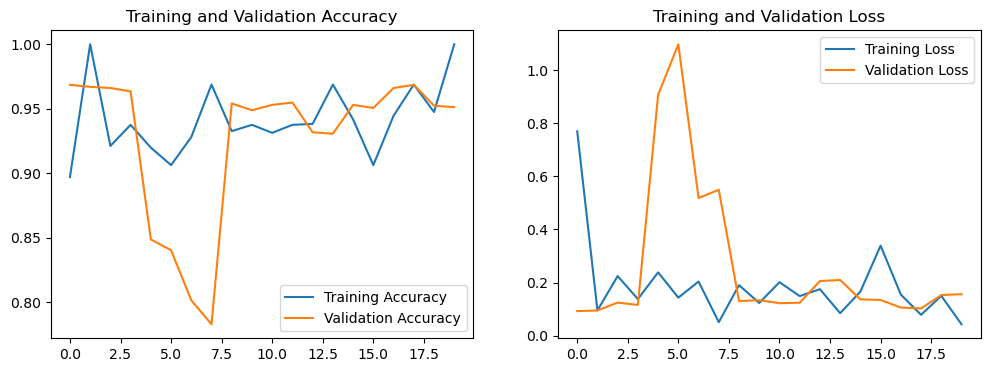

In [14]:
# Tracer l'historique d'entraînement
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()